# NTL9: hyperparameter-optimized mindist model

In [25]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import sys
sys.path.append("/Users/suarezalvareze2/Documents/workspace/NMpathAnalysis/nmpath")
import numpy as np
import pyemma
import mdtraj as md
from glob import glob
import math


from auxfunctions import *
from mfpt import *
from clustering import *
from nmm import NonMarkovModel, MarkovPlusColorModel

# Print
from IPython.display import Markdown, display

In [26]:
def plot_its(lags, model, bayesian_model, ax, ylabel, dt=2.0E-4, confidence_interval=0.98):
    cout = 50 * (1.0 - confidence_interval)
    ax.fill_between(
        lags * dt,
        0.0,
        lags * dt,
        alpha=0.5, facecolor='grey')
    ax.plot(lags * dt, lags * dt, linewidth=2, color='black')
    for i in range(model.shape[1]):
        ax.fill_between(
            lags * dt,
            np.percentile(bayesian_model[:, :, i], cout, axis=1),
            np.percentile(bayesian_model[:, :, i], 100 - cout, axis=1),
            alpha=0.3, facecolor='C%d' % i)
        ax.plot(lags * dt, model[:, i], color='C%d' % i)
        ax.plot(lags * dt, np.median(bayesian_model[:, :, i], axis=1), ':o', color='C%d' % i)
    ax.set_xlabel(r'lagtime / $\mu$s')
    ax.set_ylabel(ylabel)
    
def get_lagtime_from_array(lags, lagtime, dt=2.0E-4):
    idx = np.argmin(np.abs(lags * dt - lagtime))
    return idx, lags[idx]

def get_free_energy(tics, bins=100, use=[0, 1]):
    z, xedge, yedge = np.histogram2d(*tics[:, use].T, bins=bins)
    x = 0.5 * (xedge[:-1] + xedge[1:])
    y = 0.5 * (yedge[:-1] + yedge[1:])
    z = np.maximum(z, np.min(z[z > 0]))
    f = -np.log(z)
    f -= np.min(f)
    xx, yy = np.meshgrid(x, y)
    xy = np.array([xx.reshape(-1,), yy.reshape(-1,)]).T
    return dict(x=x, y=y, xx=xx, yy=yy, xy=xy, f=f.T, use=use)

def draw_free_energy(fe, ax, bw=False):
    if bw:
        cmap = mpl.cm.bone
        alpha=0.2
    else:
        cmap = mpl.cm.jet
        alpha=None
    levels = np.linspace(fe['f'].min(), fe['f'].max(), 100, endpoint=False)
    return ax.contourf(fe['x'], fe['y'], fe['f'], levels, cmap=cmap, alpha=alpha, vmin=0.0, vmax=np.max(fe['f']))

def get_metastable_distribution(model, state):
    pi = model.stationary_distribution.copy()
    for i, s in enumerate(model.metastable_sets):
        if i == state:
            continue
        pi[s] = 0.0
    pi /= pi.sum()
    return pi

def printmd(string):
    display(Markdown(string))

def plot_t_AB(t_cut_values, t_min_list, t_max_list, t_AB_list):
    t_cut_values_ns = np.array(t_cut_values)*dt
    t_min_list_ns = np.array(t_min_list)*dt
    t_max_list_ns = np.array(t_max_list)*dt
    t_AB_list_ns = np.array(t_AB_list)*dt

    fig = plt.figure(figsize=(15,3))

    ax1 =  fig.add_subplot(131)
    ax1.plot(t_cut_values_ns , t_AB_list_ns, "-o")
    ax1.set_xlabel("$t_{cut}\mathrm{(ns)}$", fontsize = 18)
    ax1.set_ylabel("$t_{AB}\mathrm{(ns)}$", fontsize = 18)
    #ax1.set_xlim(40,105)

    ax2 =  fig.add_subplot(132)
    ax2.plot(t_cut_values_ns, t_AB_list_ns/t_cut_values_ns, "-o",c="r")
    ax2.set_xlabel("$t_{cut}\mathrm{(ns)}$", fontsize = 18)
    ax2.set_ylabel("$t_{AB} / t_{cut}$", fontsize = 18)
    #ax2.set_xlim(40,105)

    ax3 =  fig.add_subplot(133)
    ax3.plot(t_cut_values_ns, t_max_list_ns/t_cut_values_ns, "-o",c="g")
    ax3.set_xlabel("$t_{cut}\mathrm{(ns)}$", fontsize = 18)
    ax3.set_ylabel("$t_{max} / t_{cut}$", fontsize = 18)
    #ax3.set_xlim(40,105)

    plt.show()

def plot_rmsd_histogram_clusters(t_cut_values, big_clusters_list, rmsd, dt, dtrajs, step=100):
    max_ = len(t_cut_values)
    select_to_plot= range(0, max_ ,3) # This will print the first column of the free energy plots


    for i in select_to_plot:
        macrostates = big_clusters_list[i]
        rmsd_cluster0=[]
        rmsd_cluster1=[]

        for j, microstate in enumerate(dtrajs[0]):  # There is only one traj
            if j%step == 0:
                if microstate in macrostates[0]:
                    rmsd_cluster0.append(rmsd[j])
                elif (len(macrostates) > 1) and microstate in macrostates[1]:
                    rmsd_cluster1.append(rmsd[j])

        fig = plt.figure(figsize=(5,2))

        plt.hist(rmsd_cluster0, normed=True, bins=25, alpha=0.5,label="cluster-0", edgecolor="r")
        
        if len(macrostates) > 1:
            plt.hist(rmsd_cluster1,normed=True, bins=25, color="b", 
                     alpha=0.5,label="cluster-1", edgecolor="b")

        plt.xlabel("RMSD$(\AA)$",fontsize=12)
        plt.ylabel("Probability Dens.",fontsize=12)
        plt.legend()
        #plt.title("t_cut: {:.2f}ns".format(t_cut_values_ns[i]))
        plt.annotate("t_cut: {:.2f}ns".format(t_cut_values[i]*dt), xy=(1,2))
        plt.xlim([0,7])
        plt.show()

def rmsd_of_cluster(cluster, rmsd, dtraj):
    rmsd_list=[]
    for i,element in enumerate(rmsd):
        if dtraj[i] in cluster:
            rmsd_list.append(element)
    length = len(rmsd_list)
    
    if length == 0:
        return None

    return sum(rmsd_list)/length


color_sequence = ['#d62728', '#ff9896', '#9467bd',
                  '#8c564b', '#c49c94', '#e377c2', '#f7b6d2', '#7f7f7f',
                  '#c7c7c7', '#bcbd22', '#dbdb8d', '#17becf', '#9edae5', '#98df8a']

## Data source

In [27]:
path  = '/Users/suarezalvareze2/Documents/DESHAWTRAJS/DESRES-Trajectory_NTL9-0-protein/NTL9-0-protein/'
path2 = '/Users/suarezalvareze2/Documents/DESHAWTRAJS/DESRES-Trajectory_NTL9-2-protein/NTL9-2-protein/'
path3 = '/Users/suarezalvareze2/Documents/DESHAWTRAJS/DESRES-Trajectory_NTL9-3-protein/NTL9-3-protein/'
trajs = 'NTL9-0-protein-*.dcd'
trajs2 = 'NTL9-2-protein-*.dcd'
trajs3 = 'NTL9-3-protein-*.dcd'

traj_files = [f for f in sorted(glob(path + trajs))] 
traj_files2 = [f for f in sorted(glob(path2 + trajs2))]
traj_files3 = [f for f in sorted(glob(path3 + trajs3))]

pdb_file = path + 'NTL9.pdb'

## Create a feature reader


In [28]:
features = pyemma.coordinates.featurizer(pdb_file)
features.add_residue_mindist()
features.add_minrmsd_to_ref(path + 'NTL9-0-protein-019.dcd', ref_frame=1000)
source = pyemma.coordinates.source([traj_files], features=features, chunk_size=100000)

03-05-18 10:59:42 pyemma.coordinates.data.featurization.featurizer.MDFeaturizer[4] WARNING  Using all residue pairs with schemes like closest or closest-heavy is very time consuming. Consider reducing the residue pairs


## Discretization

Following an extensive hyperparameter screening, I found that a TICA lagtime of 200 steps and projecting onto the first 30 eigenvectors yields the best implied timescale convergence.

To accoutn for the high dimensionality, I recommend to use at least 500 discrete states.

In [29]:
# tica = pyemma.coordinates.tica(data=source, lag=200, dim=30)
# cluster = pyemma.coordinates.cluster_kmeans(tica, k=200, max_iter=50)

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

03-05-18 13:38:39 pyemma.coordinates.clustering.kmeans.KmeansClustering[7] INFO     Cluster centers converged after 8 steps.


A Jupyter Widget

A Jupyter Widget

/Users/suarezalvareze2/anaconda3/lib/python3.6/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The spectral and spectral_r colormap was deprecated in version 2.0. Use nipy_spectral and nipy_spectral_r instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


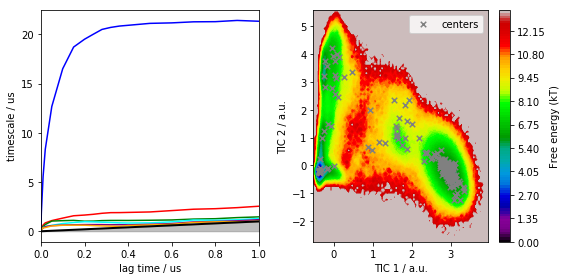

In [30]:
tica = pyemma.coordinates.tica(data=source, lag=200, dim=30).get_output()[0]
cluster = pyemma.coordinates.cluster_kmeans(tica, k=200, max_iter=50)

#lags = np.asarray([1, 5, 10, 20, 50] + [i * 100 for i in range(1, 21)])
lags=np.asarray([1, 10, 50, 100, 250, 500, 750, 1000,
            1200, 1400, 1600, 1800, 2000, 2500,
            3000, 3500, 4000, 4500, 5000])
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
pyemma.plots.plot_implied_timescales(
    pyemma.msm.its(cluster.dtrajs, lags=lags, errors=None, nits=6),
    ylog=False, ax=axes[0], units='us', dt=2.0E-4)
pyemma.plots.plot_free_energy(*tica[:, :2].T, ax=axes[1])
axes[1].scatter(*cluster.clustercenters[:,:2].T, marker='x', c='grey', s=30, label='centers')
axes[1].legend()
axes[1].set_xlabel('TIC 1 / a.u.')
axes[1].set_ylabel('TIC 2 / a.u.')
fig.tight_layout()

## CK test

We estimate an MSM at lagtime $\tau$=1500 steps and run a series of CK tests for two, three and four metastable sets.

A Jupyter Widget

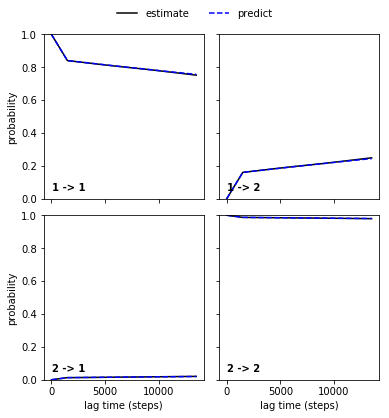

In [31]:
msm = pyemma.msm.estimate_markov_model(cluster.dtrajs, lag=1500, dt_traj='0.0002 us')
pyemma.plots.plot_cktest(msm.cktest(2));

A Jupyter Widget

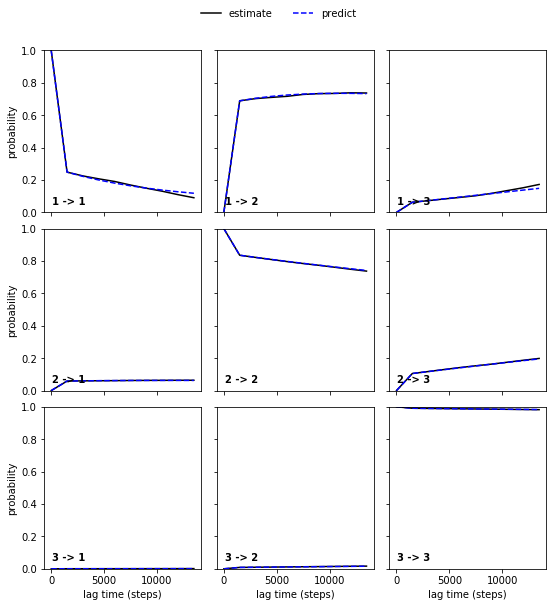

In [32]:
pyemma.plots.plot_cktest(msm.cktest(3));

A Jupyter Widget

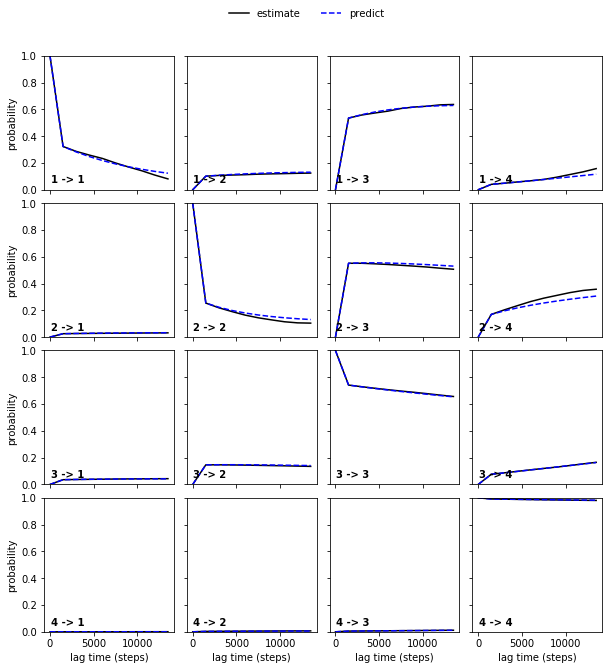

In [33]:
pyemma.plots.plot_cktest(msm.cktest(4));

Apparently, the two metastable state choice yields the best result.

## Timescales

Let's coarse grain the estimated MSM to two states and compute timescales and mean MFPTs for this HMM; the corresponding quantities of the MSM are shown, too.

In [34]:
hmm2 = msm.coarse_grain(2)
print('HMM: %7.2f us' % hmm2.timescales(k=1))
print('MSM: %7.2f us' % msm.timescales(k=1))

HMM:   15.44 us
MSM:   20.62 us


In [35]:
print('HMM: %7.2f us' % hmm2.mfpt(0, 1))
print('MSM: %7.2f us' % msm.mfpt(hmm2.metastable_sets[0], hmm2.metastable_sets[1]))

HMM:   17.22 us
MSM:   21.49 us


In [36]:
print('HMM: %7.2f us' % hmm2.mfpt(1, 0))
print('MSM: %7.2f us' % msm.mfpt(hmm2.metastable_sets[1], hmm2.metastable_sets[0]))

HMM:  164.87 us
MSM:   81.70 us


## Summary

The HMM (and MSM) MFPTs are in very good agreement with the range of (un-)folding timescales in the literature. Sampling frames from both states and visualizing their molecular structures would show which metsatable states were found by the MSM/HMM modelling.

# PART 2: Post Analyses 

### RMSD

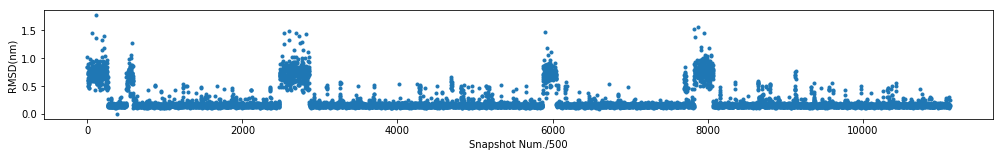

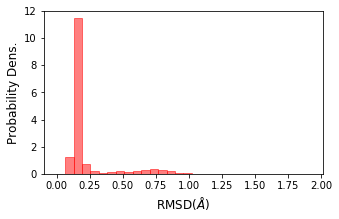

In [37]:
reference = md.load_dcd(path + 'NTL9-0-protein-019.dcd', top=pdb_file)

CA_atoms = reference.topology.select('name CA and resid 2 to 36')


rmsd = []

for traj_name in traj_files:
    traj = md.load_dcd(traj_name, top=pdb_file)
    for element in md.rmsd(traj, reference, 1000, atom_indices=CA_atoms):
        rmsd.append(element)

fig = plt.figure(figsize=(17, 2))
plt.plot(rmsd[::500],".")
#plt.axis([0, 1000, 0.0, 1.5])
plt.ylabel('RMSD(nm)')
plt.xlabel('Snapshot Num./500')
plt.show()


#histogram
fig = plt.figure(figsize=(5, 3))

ax1 = fig.add_subplot(111)
ax1.hist(rmsd[::100], normed=True, bins=30, color='r', alpha=0.5, edgecolor='r')
ax1.set_xlabel('RMSD$(\AA)$', fontsize=12)
ax1.set_ylabel('Probability Dens.', fontsize=12)

# to Angstrom
rmsd = np.array(rmsd) * 10.0

### Agglomerative Clustering from the transition matrix

Hierarchical agglomerative clustering using the Markovian commute time: $t_{ij} = \mathrm{MFPT}(i \rightarrow j)+ \mathrm{MFPT}(j \rightarrow i)$.

IMPORTANT: The goal of this clusterig is tho identify macrostates and not to use the best lag-time, the lag-time use for clustering could different from the one that would be appropiate for the final Markov model.

### Lag time = 1 step (just for clustering)

In [38]:
msm1 = pyemma.msm.estimate_markov_model(cluster.dtrajs, lag=1, dt_traj='0.0002 us')

In [39]:
lags=np.array([1, 10, 50, 100, 250, 500, 750, 1000,1200, 1400, 1600, 1800, 2000, 2500,3000, 3500, 4000, 4500, 5000])
lag_to_use = [1]
lag_index = [ get_lagtime_from_array(lags, element*0.2)[0] for element in lag_to_use ]
#range_per_lag = [[3000,8000]]
range_per_lag = [[2000,8000]]

### Clustering

### Lag-time: 0.2ns

#### t_values:

t_cut: 400.00ns, t_min: 425.00ns, t_max: 2.73e+05ns, tAB: 3814.82ns


/Users/suarezalvareze2/anaconda3/lib/python3.6/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The spectral and spectral_r colormap was deprecated in version 2.0. Use nipy_spectral and nipy_spectral_r instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


t_cut: 480.00ns, t_min: 483.24ns, t_max: 2.73e+05ns, tAB: 3814.82ns
t_cut: 560.00ns, t_min: 580.59ns, t_max: 2.73e+05ns, tAB: 3814.82ns
t_cut: 640.00ns, t_min: 648.15ns, t_max: 2.73e+05ns, tAB: 3814.82ns
t_cut: 720.00ns, t_min: 722.58ns, t_max: 2.73e+05ns, tAB: 3814.82ns
t_cut: 800.00ns, t_min: 815.37ns, t_max: 2.73e+05ns, tAB: 3814.82ns
t_cut: 880.00ns, t_min: 894.92ns, t_max: 2.73e+05ns, tAB: 3814.82ns
t_cut: 960.00ns, t_min: 988.01ns, t_max: 2.73e+05ns, tAB: 3814.82ns
t_cut: 1040.00ns, t_min: 1048.42ns, t_max: 2.73e+05ns, tAB: 3814.82ns
t_cut: 1120.00ns, t_min: 1203.37ns, t_max: 2.73e+05ns, tAB: 3814.82ns
t_cut: 1200.00ns, t_min: 1203.37ns, t_max: 2.73e+05ns, tAB: 3814.82ns
t_cut: 1280.00ns, t_min: 1280.47ns, t_max: 2.73e+05ns, tAB: 3814.82ns
t_cut: 1360.00ns, t_min: 1377.15ns, t_max: 2.71e+05ns, tAB: 4531.82ns
t_cut: 1440.00ns, t_min: 1473.07ns, t_max: 2.71e+05ns, tAB: 579.44ns
t_cut: 1520.00ns, t_min: 1555.77ns, t_max: 2.71e+05ns, tAB: 579.44ns


#### Observed clusters vs t_cut

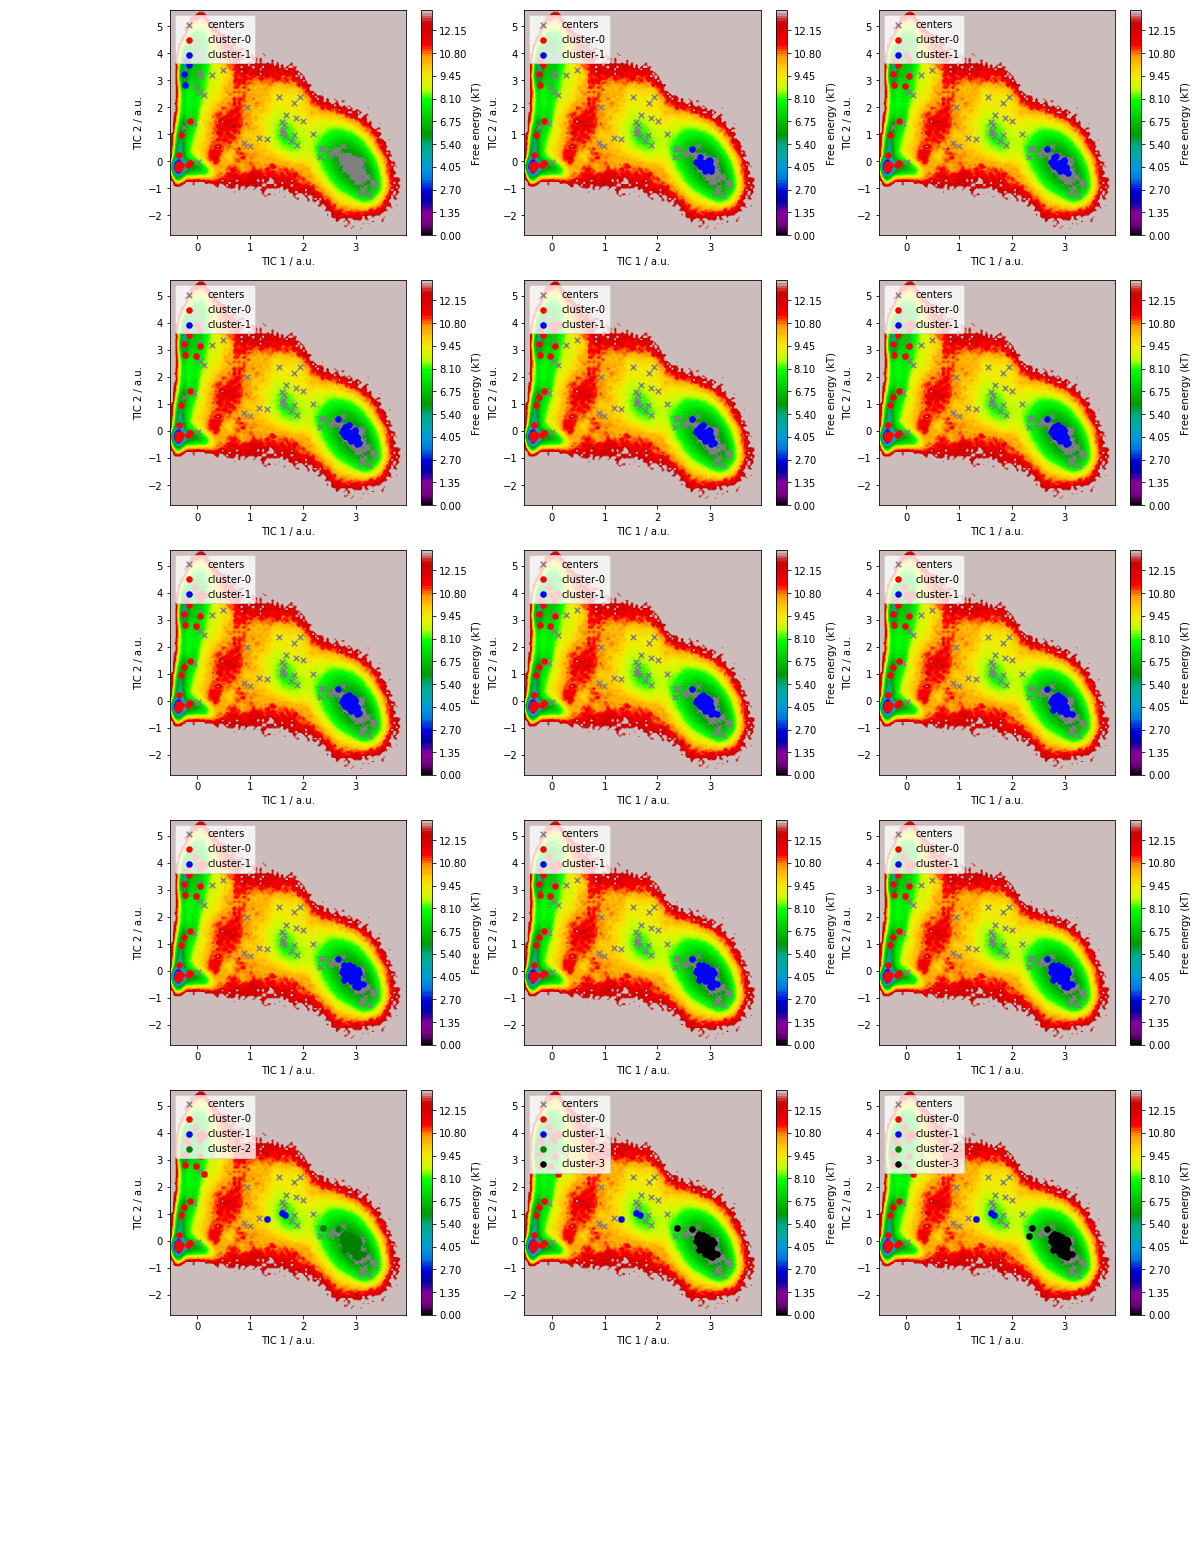

#### t_AB plots:

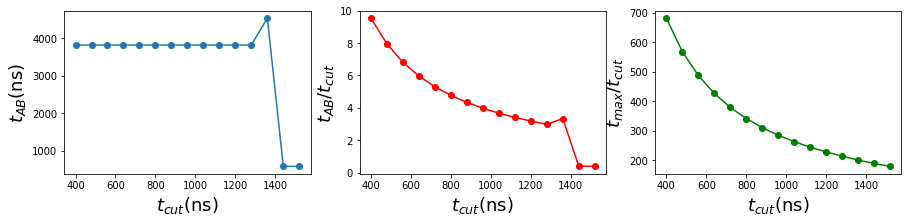

In [40]:
K = msm1.P
dt = 0.2
#---------------------
printmd("### Lag-time: "+str(dt)+"ns")

t_min_list=[]
t_max_list=[]
t_AB_list=[]

big_clusters_list = []

# t_cut range
min_ = range_per_lag[0][0]
max_ = range_per_lag[0][1]
interval = (max_ - min_)//15 
t_cut_values =  [min_+i for i in range(0,max_- min_,interval)][0:15]


fig_n_cols = 3
fig_n_rows = int(math.ceil(len(t_cut_values)/fig_n_cols))


fig = plt.figure(figsize=(6*fig_n_cols, 4.8*fig_n_rows))

printmd("#### t_values:")

for ii, t_cut in enumerate(t_cut_values):

    big_clusters=[]
    big_clusters_index =[]

    # clustering
    clusters, t_min, t_max, clustered_tmatrix = kinetic_clustering_from_tmatrix(K, t_cut=t_cut, verbose=False)
    #clusters, t_min, t_max = kinetic_clustering2_from_tmatrix(K, t_cut=t_cut, verbose=False)


    t_min_list.append(t_min)
    t_max_list.append(t_max)

    for i, cluster_i in enumerate(clusters):
        if len(cluster_i) > 1:
            big_clusters.append(cluster_i)
            big_clusters_index.append(i)

    n_big = len(big_clusters)

    macrostates = biggest_clusters_indexes(big_clusters, n_pick=2)
    #macrostates_list.append([ clusters[macrostates[i]] for i in range(len(macrostates))])
    big_clusters_list.append(big_clusters)

    if n_big > 1:
        #tAB = markov_commute_time(clustered_tmatrix,[macrostates[0]],[macrostates[1]] )
        tAB = markov_commute_time(K,[macrostates[0]],[macrostates[1]] )
    else:
        tAB = 0.0
    t_AB_list.append(tAB)

    print("t_cut: {:.2f}ns, t_min: {:.2f}ns, t_max: {:.2e}ns, tAB: {:.2f}ns".format(t_cut*dt, t_min*dt, t_max*dt, tAB*dt))

    plt.subplot(fig_n_rows, fig_n_cols, ii+1)
    pyemma.plots.plot_free_energy(*tica[:,:2].T)
    plt.scatter(*cluster.clustercenters[:,:2].T, marker='x', c='grey', s=30, label='centers')
    plt.annotate("t_cut: {:.2f}ns".format(t_cut*dt), xy=(-0.8,-4))

    colors = ['red','blue','green','black','orange'] + color_sequence

    for i, cluster_i in enumerate(big_clusters):
        cluster_i_tica_xy = []
        for index in cluster_i:
            cluster_i_tica_xy.append(cluster.clustercenters[:,:2][index])
        cluster_i_tica_xy = np.array(cluster_i_tica_xy)
        plt.scatter(*cluster_i_tica_xy.T, marker='o', c=colors[i], s=30, label='cluster-'+str(i))

    plt.legend(loc='upper left')
    plt.xlabel('TIC 1 / a.u.')
    plt.ylabel('TIC 2 / a.u.')
        
printmd("#### Observed clusters vs t_cut")
plt.show()

printmd("#### t_AB plots:")
plot_t_AB(t_cut_values, t_min_list, t_max_list, t_AB_list)

# Selecting t_cut = 800ns for mfpts calculations and definition of macrostates

The two biggest clusters in terms of the number of states are selected. The one with the smallest RMSD is considered folded and the other unfolded.

In [41]:
#Selection of the t_cut
macrostates = biggest_clusters_indexes(big_clusters_list[4], n_pick=2)

# Folded and unfolded definition
stateA = big_clusters_list[6][macrostates[0]]
stateB = big_clusters_list[6][macrostates[1]]

rmsdA = rmsd_of_cluster(stateA, rmsd, cluster.dtrajs[0])
rmsdB = rmsd_of_cluster(stateB, rmsd, cluster.dtrajs[0])

#stateA is always the unfolded state
if rmsdB > rmsdA:
    stateA, stateB = stateB, stateA

print("RMSD folded:   ", rmsdB )
print("RMSD unfolded: ", rmsdA )

RMSD folded:    1.59731242911
RMSD unfolded:  7.79322172736


In [42]:
dt = 0.0002 # in micro-sec

lag_to_use = np.asarray(list(lags[0::2]) + [5000, 10000, 15000, 20000, 30000])

lag_index = [ get_lagtime_from_array(lags, element*0.2)[0] for element in lag_to_use ]

# MSM estimation
msm_models = [pyemma.msm.estimate_markov_model(cluster.dtrajs, lag=lag, dt_traj='0.0002 us') for lag in lag_to_use]

msm_mfptAB = np.asarray([msm_models[i].mfpt(stateA, stateB) for i in range(len(lag_to_use))])
msm_mfptBA = np.asarray([msm_models[i].mfpt(stateB, stateA) for i in range(len(lag_to_use))])

In [43]:
model1 = NonMarkovModel(cluster.dtrajs, stateA, stateB)
model1.popA, model1.popB

(0.054887975211580314, 0.88303280570821752)

In [44]:
kinetics = model1.mfpts()
dt = 0.0002
print(kinetics['mfptAB']*dt,kinetics['mfptBA']*dt)

2.76161950523 24.9755092038


In [45]:
kinetics = model1.empirical_mfpts()
print(kinetics['mfptAB']*dt,kinetics['mfptBA']*dt)

Number of A->B/B->A  events: 41/40
2.7617512195121954 19.98395


## Empirical and non-Markovian estimates

In [54]:
dt=0.0002

empirical_mfptsAB =[]
empirical_mfptsBA =[]
nm_mfptsAB = []
nm_mfptsBA = []

std_errAB = []
std_errBA = []

nm_hist10ns_mfptsAB = []
nm_hist10ns_mfptsBA = []

nm_hist20ns_mfptsAB = []
nm_hist20ns_mfptsBA = []

#nm_hist50ns_mfptsAB = []
#nm_hist50ns_mfptsBA = []

#nm_hist100ns_mfptsAB = []
#nm_hist100ns_mfptsBA = []



for i, lag in enumerate(lag_to_use):
    
    nm_model = NonMarkovModel(cluster.dtrajs, stateA, stateB, lag_time=lag, sliding_window=True)
    
    # markov + color
    nm_model_hist10ns  = MarkovPlusColorModel(cluster.dtrajs, stateA, stateB, lag_time=lag, hist_length=50)
    nm_model_hist20ns  = MarkovPlusColorModel(cluster.dtrajs, stateA, stateB, lag_time=lag, hist_length=100)
    #nm_model_hist50ns  = MarkovPlusColorModel(cluster.dtrajs, stateA, stateB, lag_time=lag, hist_length=250)
    #nm_model_hist100ns = MarkovPlusColorModel(cluster.dtrajs, stateA, stateB, lag_time=lag, hist_length=500)
    
    nm_kinetics = nm_model.mfpts()
    nm_model_hist10ns_kinetics = nm_model_hist10ns.mfpts()
    nm_model_hist20ns_kinetics = nm_model_hist20ns.mfpts()
    #nm_model_hist50ns_kinetics = nm_model_hist50ns.mfpts()
    #nm_model_hist100ns_kinetics = nm_model_hist100ns.mfpts()
    
    e_kinetics = nm_model.empirical_mfpts()
    
    
    empirical_mfptsAB.append(e_kinetics['mfptAB']*dt)
    empirical_mfptsBA.append(e_kinetics['mfptBA']*dt)
    
    std_errAB.append(e_kinetics['std_err_mfptAB']*dt)
    std_errBA.append(e_kinetics['std_err_mfptBA']*dt)
    
    nm_mfptsAB.append(nm_kinetics['mfptAB']*dt)
    nm_mfptsBA.append(nm_kinetics['mfptBA']*dt)
    
    nm_hist10ns_mfptsAB.append(nm_model_hist10ns_kinetics['mfptAB']*dt)
    nm_hist10ns_mfptsBA.append(nm_model_hist10ns_kinetics['mfptBA']*dt)
    
    nm_hist20ns_mfptsAB.append(nm_model_hist20ns_kinetics['mfptAB']*dt)
    nm_hist20ns_mfptsBA.append(nm_model_hist20ns_kinetics['mfptBA']*dt)
    
    #nm_hist50ns_mfptsAB.append(nm_model_hist50ns_kinetics['mfptAB']*dt)
    #nm_hist50ns_mfptsBA.append(nm_model_hist50ns_kinetics['mfptBA']*dt)
    
    #nm_hist100ns_mfptsAB.append(nm_model_hist100ns_kinetics['mfptAB']*dt)
    #nm_hist100ns_mfptsBA.append(nm_model_hist100ns_kinetics['mfptBA']*dt)

Number of A->B/B->A  events: 41/40
Number of A->B/B->A  events: 7/6
Number of A->B/B->A  events: 6/5
Number of A->B/B->A  events: 5/4
Number of A->B/B->A  events: 5/4
Number of A->B/B->A  events: 5/4
Number of A->B/B->A  events: 6/5
Number of A->B/B->A  events: 5/4
Number of A->B/B->A  events: 6/5
Number of A->B/B->A  events: 5/4
Number of A->B/B->A  events: 5/4
Number of A->B/B->A  events: 5/4
Number of A->B/B->A  events: 5/4
Number of A->B/B->A  events: 5/4
Number of A->B/B->A  events: 4/3


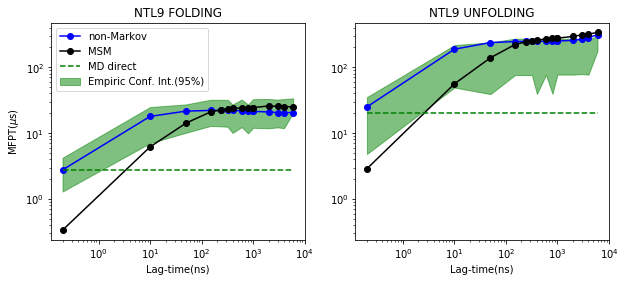

In [47]:
lag_to_use_ns = np.array(lag_to_use) * 0.2

empirical_mfptAB_max = np.array(empirical_mfptsAB) + 2*np.array(std_errAB)
empirical_mfptAB_min = np.array(empirical_mfptsAB) - 2*np.array(std_errAB)

empirical_mfptBA_max = np.array(empirical_mfptsBA) + 2*np.array(std_errBA)
empirical_mfptBA_min = np.array(empirical_mfptsBA) - 2*np.array(std_errBA)


fig=plt.figure(figsize = (10,4))

ax1 = fig.add_subplot(121)
ax1.fill_between(lag_to_use_ns, empirical_mfptAB_min, empirical_mfptAB_max,
                 alpha=0.5, color="green", label="Empiric Conf. Int.(95%)" )

ax1.plot(lag_to_use_ns, nm_hist10ns_mfptsAB, "--", label="NM(hist=10ns)", c='b')
ax1.plot(lag_to_use_ns, nm_hist50ns_mfptsAB, "-.", label="NM(hist=50ns)", c='b')
ax1.plot(lag_to_use_ns, nm_mfptsAB, "-o", label="NM(full history)", c='b')

ax1.plot(lag_to_use_ns, msm_mfptAB, "-o",color='k', label="MSM")
ax1.plot(lag_to_use_ns, [empirical_mfptsAB[0] for i in lag_to_use_ns], "--", color='green',label='MD direct')
#ax1.plot(lag_to_use_ns, lag_to_use_ns/nm_model.popA/1000, c='purple')
ax1.set_xscale("log")
ax1.set_yscale("log")
ax1.set_title("NTL9 FOLDING")
ax1.set_xlabel("Lag-time(ns)")
ax1.set_ylabel("MFPT($\mu$s)")
plt.legend(loc='upper left')
#ax1.set_xlim(0,600)


ax2 = fig.add_subplot(122, sharey=ax1)
ax2.fill_between(lag_to_use_ns, empirical_mfptBA_min, empirical_mfptBA_max,
                 alpha=0.5, color="green", label="Empiric Conf. Int.(95%)" )

ax2.plot(lag_to_use_ns, nm_hist10ns_mfptsBA, "--", label="NM(hist=10ns)", c='b')
ax2.plot(lag_to_use_ns, nm_hist50ns_mfptsBA, "-.", label="NM(hist=50ns)", c='b')
ax2.plot(lag_to_use_ns, nm_mfptsBA, "-o", label="NM(full history)", c='b' )

ax2.plot(lag_to_use_ns, msm_mfptBA, "-o",color='k', label="MSM")
#ax2.plot(lag_to_use_ns, lag_to_use_ns/nm_model.popB/1000, color='purple')
ax2.set_xscale("log")
ax2.set_yscale("log")
ax2.set_title("NTL9 UNFOLDING")
ax2.set_xlabel("Lag-time(ns)")
#ax2.set_xlim(0,600)

ax2.plot(lag_to_use_ns, [empirical_mfptsBA[0] for i in lag_to_use_ns], "--", color='green', label='MD direct')
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


plt.show()

## Markov + Color : History Analysis (Lag=1tau)

In [48]:
dt =0.0002

discrete_traj = cluster.dtrajs

history = np.array([0, 50, 100, 300, 500])
mpc_mfptsAB = []
mpc_mfptsBA = []

for hist in history:
    print("hist = ", hist)
    model = MarkovPlusColorModel(discrete_traj, stateA, stateB, hist_length=hist)
    kinetics = model.mfpts()
    mpc_mfptsAB.append(kinetics['mfptAB']*dt)
    mpc_mfptsBA.append(kinetics['mfptBA']*dt)

# Empirical values:
emp_mfpts = model.empirical_mfpts()

emp_mfptAB = emp_mfpts['mfptAB']*dt
emp_mfptBA = emp_mfpts['mfptBA']*dt
emp_std_err_mfptAB = emp_mfpts['std_err_mfptAB']*dt
emp_std_err_mfptBA = emp_mfpts['std_err_mfptBA']*dt

hist =  0
hist =  50
hist =  100
hist =  300
hist =  500
Number of A->B/B->A  events: 41/40


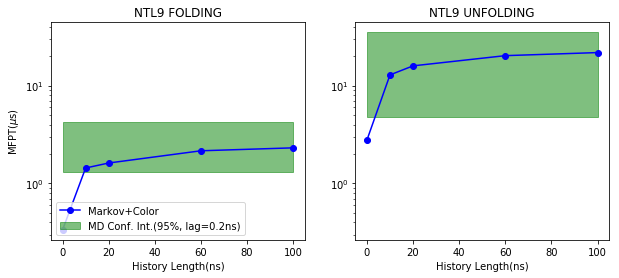

In [49]:
alpha = 0.5

fig =plt.figure(figsize = (10,4))

err_maxAB = [emp_mfptAB + 2*emp_std_err_mfptAB for _ in history]
err_minAB = [emp_mfptAB - 2*emp_std_err_mfptAB for _ in history]
err_maxBA = [emp_mfptBA + 2*emp_std_err_mfptBA for _ in history]
err_minBA = [emp_mfptBA - 2*emp_std_err_mfptBA for _ in history]

ax1 = fig.add_subplot(121)
ax1.fill_between(history*0.2, err_minAB, err_maxAB,
                 alpha=alpha, color="green", label="MD Conf. Int.(95%, lag=0.2ns)" )
ax1.plot(history*0.2, mpc_mfptsAB, "-o", label="Markov+Color", color='b')
ax1.set_yscale("log")
ax1.set_title("NTL9 FOLDING")
ax1.set_xlabel("History Length(ns)")
ax1.set_ylabel("MFPT($\mu$s)")
ax1.legend(loc='lower left')
#ax1.set_xlim(-2,80)
#ax1.set_ylim(0.01,10)

ax2 = fig.add_subplot(122, sharey=ax1)
ax2.fill_between(history*0.2, err_minBA, err_maxBA,
                 alpha=alpha, color="green", label="Conf. Int.(95%)" )
ax2.plot(history*0.2, mpc_mfptsBA, "-o", label="Markov+Color", color='b')
ax2.set_yscale("log")
ax2.set_title("NTL9 UNFOLDING")
ax2.set_xlabel("History Length(ns)")
#ax2.legend(loc='upper left')
#ax2.set_xlim(-2,80)
#ax2.set_ylim(0.01,10)

plt.show()

### t_b

In [50]:
nm_model.lag_time = 1
empiric_fptsAB, empiric_fptsBA, tb_values = nm_model.empirical_fpts()

###  Average $t_b$ = 113.26ns

###  Median $t_b$ = 0.60ns

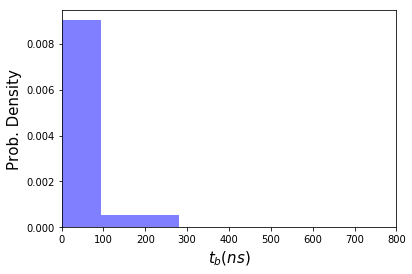

In [51]:
printmd("###  Average $t_b$ = {:.2f}ns".format(0.2*sum(tb_values)/len(tb_values)))
printmd("###  Median $t_b$ = {:.2f}ns".format(0.2*np.median(tb_values)))

plt.hist(np.array(tb_values)*0.2, normed=True, bins=30, color='blue', alpha=0.5)
plt.xlabel("$t_b (ns)$", fontsize=15)
plt.ylabel("Prob. Density", fontsize=15)
plt.annotate
plt.xlim([0,800])
plt.show()

## Correlation functions

In [59]:
times =  range(1500, 30000, 1500)
times_in_us = np.array(times)*0.0002

emp_coorAB = nm_model.empirical_corr_function(nm_model.stateA, nm_model.stateB, times=times)
emp_coorAA = nm_model.empirical_corr_function(nm_model.stateA, nm_model.stateA, times=times)
emp_coorBB = nm_model.empirical_corr_function(nm_model.stateB, nm_model.stateB, times=times)

                                              LAG TIME: 0.2ns


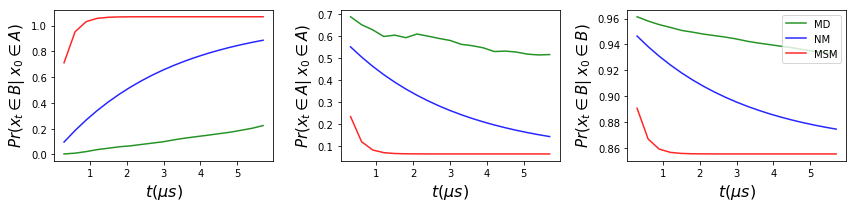

                                              LAG TIME: 2.0ns


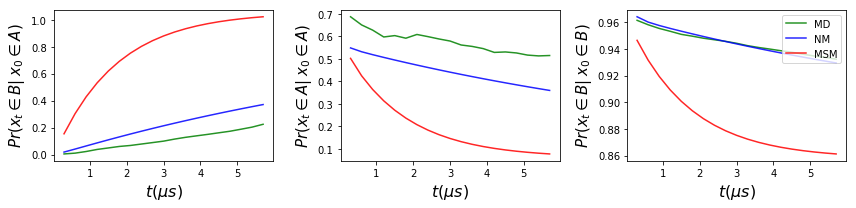

                                              LAG TIME: 10.0ns


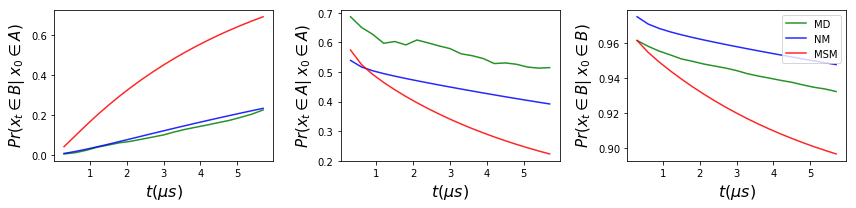

                                              LAG TIME: 100.0ns


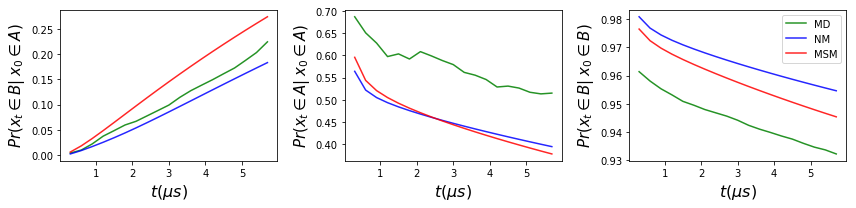

                                              LAG TIME: 300.0ns


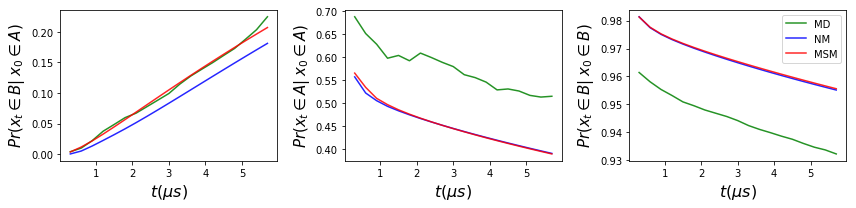

In [70]:
pA = nm_model.popA
pB = nm_model.popB

alpha = 0.85

for lag in [1, 10, 50, 500, 1500]:

    nm_model.lag_time=lag
    print(46*' ' + 'LAG TIME: {}ns'.format(lag*0.2))

    nm_pAA, nm_pAB, nm_pBA, nm_pBB = nm_model.corr_function(times=times)
    
    nm_model.markovian = True
    msm_pAA, msm_pAB, msm_pBA, msm_pBB = nm_model.corr_function(times=times)
    nm_model.markovian = False

    fig = plt.figure(figsize=(12,3))
    fig.add_subplot(131)
    plt.plot(times_in_us, emp_coorAB/pA, label='MD', color='green', alpha=alpha)
    plt.plot(times_in_us, nm_pAB/pA, label='NM', color='blue', alpha=alpha)
    plt.plot(times_in_us, msm_pAB/pA, label='MSM', color='red', alpha=alpha)
    plt.xlabel('$t(\mu s)$', fontsize=16)
    plt.ylabel('$Pr(x_t \in B|\; x_0 \in A)$', fontsize=15)
    #plt.ylim([0,0.2])

    fig.add_subplot(132)
    plt.plot(times_in_us, emp_coorAA/pA, label='MD', color='green', alpha=alpha)
    plt.plot(times_in_us, nm_pAA/pA, label='NM', color='blue', alpha=alpha)
    plt.plot(times_in_us, msm_pAA/pA, label='MSM', color='red', alpha=alpha)
    plt.xlabel('$t(\mu s)$', fontsize=16)
    plt.ylabel('$Pr(x_t \in A|\; x_0 \in A)$', fontsize=15)
    #plt.ylim([0.5,1])
    
    fig.add_subplot(133)
    plt.plot(times_in_us, emp_coorBB/pB, label='MD', color='green', alpha=alpha)
    plt.plot(times_in_us, nm_pBB/pB, label='NM', color='blue', alpha=alpha)
    plt.plot(times_in_us, msm_pBB/pB, label='MSM', color='red', alpha=alpha )
    plt.xlabel('$t(\mu s)$', fontsize=16)
    plt.ylabel('$Pr(x_t \in B|\; x_0 \in B)$', fontsize=15)
    plt.legend(loc='upper right')
    #plt.ylim([0.5,1])

    fig.tight_layout()

    plt.show()